# Quem suportou quem: os votos na generalidade

```{epigraph}
“Just the place for a Snark!” the Bellman cried, \
   As he landed his crew with care; \
Supporting each man on the top of the tide \
   By a finger entwined in his hair. \
 \
“Just the place for a Snark! I have said it twice: \
   That alone should encourage the crew. \
Just the place for a Snark! I have said it thrice: \
   What I tell you three times is true.”

-- Lewis Carrol, «The Hunting of the Snark»
```

## Metodologia

A obtenção dos dados e parte substancial do seu tratamento é idêntica a utilizada nas outras análises, com uma alteração que permite a obtenção de uam nova dimensão de dados, muito semelhante à utilizada na análise do Orçamento de Estados: o perfil de votações tendo em conta a origem da proposta.

Se no Orçamento de Estado esta informação é simples de obter, nas iniciativas parlamentares é menos óbvia: uma votação associada a uma iniciativa de determinado partido não pode ser classificada como sendo uma votação sobre algo proposto por esse mesmo partido. A razão é simples: as votações podem ser, por exemplo, sobre propostas de alteração, e estas podem ter múltiplas origens.

```{margin}
Já foi testada uma análise assente na primeira opção, e sendo funcional, foram sendo descobertas pequenas excepções que levavam ao permanente aprimoramento dos padrões textuais usados. Até uma maior validação dos dados seria imprudente assentar a análise nesta abordagem.
```

Existem duas soluções para esta questão:

1. Proceder a uma análise textual que permita identificar a origem da votação em causa, isto porque a única forma de proceder à sua identificação é pelo tratamento de um campo em texto livre (por exemplo, "Proposta de alteração de XXX - artigo 40", mas com várias permutações).
2. Isolar uma determinada categoria de votação que permita a imputação de autoria de forma directa.


Optámos pela opção 2, pela maior fiabilidade dos resultados, sob a forma de isolamento das Votações na Generalidade - que são, das que cumprem o requisito, as que são em amior número, e também aquelas que à partida melhor representam os projectos postos a votação (por não serem alvo de alterações na especialdiade que podem ser substanciais).


In [1]:
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#sns.set(font="EB Garamond")
sns.set_theme(style="whitegrid", palette="pastel")
from myst_nb import glue
%matplotlib inline

In [2]:
## Get the data
from urllib.request import urlopen
import xml.etree.ElementTree as ET

#l13_ini_url = 'https://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a686379395953556c4a4a5449775447566e61584e7359585231636d45765357357059326c6864476c3259584e5953556c4a4c6e687462413d3d&fich=IniciativasXIII.xml&Inline=true'
#l13_ini_tree = ET.parse(urlopen(l13_ini_url))
l13_ini_file = './l13_ini.xml'
l13_ini_tree = ET.parse(l13_ini_file)
l14_ini_file = './l14_ini.xml'
l14_ini_tree = ET.parse(l14_ini_file)


In [3]:
from bs4 import BeautifulSoup
import re
import pandas as pd

## Iteract through the existing dict
def party_from_votes (votes):
    """
    Determines the position of a party based on the majority position by summing all the individual votes.
    Argument is a dictionary returned by parse_voting()
    Returns a dictionary with the majority position of each party
    """
    party_vote = {}
    for k, v in votes.items():
        ## Erase the name of the MP and keep the party only
        ## only when it's not from the "Ninsc" group - 
        ## these need to be differentiated by name
        if re.match(".*\(Ninsc\)" , k) is None:
            nk = re.sub(r".*\((.+?)\).*", r"\1", k)
        else:
            nk = k
        ## If it's the first entry for a key, create it
        if nk not in party_vote:
            party_vote[nk] = [0,0,0]
        ## Add to a specific index in a list
        if v == "A Favor":
            party_vote[nk][0] += 1
        elif v == "Abstenção":
            party_vote[nk][1] += 1
        elif v == "Contra":
            party_vote[nk][2] += 1
    for k,v in party_vote.items():
        party_vote[k]=["A Favor", "Abstenção", "Contra"][v.index(max(v))]
    return party_vote

def parse_voting(v_str):
    """Parses the voting details in a string and returns a dict.
    
    Keyword arguments:
    
    v_str: a string with the description of the voting behaviour.
    """
    ## Split by the HTML line break and put it in a dict
    d = dict(x.split(':') for x in v_str.split('<BR>'))
    ## Remove the HTML tags
    for k, v in d.items():
        ctext = BeautifulSoup(v, "lxml")
        d[k] = ctext.get_text().strip().split(",")
    ## Invert the dict to get a 1-to-1 mapping
    ## and trim it
    votes = {}
    if len(v_str) < 1000:    # Naive approach but realistically speaking... works well enough.
        for k, v in d.items():
            for p in v:
                if (p != ' ' and                                       # Bypass empty entries
                    re.match("[0-9]+", p.strip()) is None and           # Bypass quantified divergent voting patterns
                    (re.match(".*\w +\(.+\)", p.strip()) is None or     # Bypass individual votes...
                     re.match(".*\(Ninsc\)" , p.strip()) is not None)): # ... except when coming from "Ninsc"
                        #print("|"+ p.strip() + "|" + ":\t" + k)
                        votes[p.strip()] = k
    else:  # This is a nominal vote since the size of the string is greater than 1000
        for k, v in d.items():
            for p in v:
                if p != ' ':
                    votes[p.strip()] = k
        ## Call the auxiliary function to produce the party position based on the majority votes
        votes = party_from_votes(votes)
    return votes

In [4]:
import collections

def ini_to_df(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for voting in root.findall(".//pt_gov_ar_objectos_VotacaoOut"):
        votep = voting.find('./detalhe')
        if votep is not None:
            init_dict = collections.OrderedDict()
            counter +=1                 
            init_dict['id'] = voting.find('id').text
            ## Add the "I" for Type to mark this as coming from "Iniciativas"
            init_dict['Tipo'] = "I"
            for c in voting:
                if c.tag == "detalhe":
                    for party, vote in parse_voting(c.text).items():
                        init_dict[party] = vote 
                elif c.tag == "descricao":
                        init_dict[c.tag] = c.text
                elif c.tag == "ausencias":
                        init_dict[c.tag] = c.find("string").text
                else:
                        init_dict[c.tag] = c.text
            init_list.append(init_dict)
        ## Provide progression feedback
        #print('.', end='')
    return pd.DataFrame(init_list)
        
#print(counter)

In [5]:

def ini_to_df_ini(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for ini in root.findall("pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut"):
        for evento in ini.iter("pt_gov_ar_objectos_iniciativas_EventosOut"):
            for voting in evento.iter("pt_gov_ar_objectos_VotacaoOut"):
                votep = voting.find('./detalhe')
                if votep is not None:
                    init_dict = collections.OrderedDict()
                    counter +=1
                    init_dict["fase"] = evento.find("fase").text
                    for c in ini:
                        if c.tag == "iniAutorGruposParlamentares" or c.tag == "iniAutorDeputados":
                            if c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP') is not None:
                                init_dict[c.tag] = c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP').text
                            elif c.find('pt_gov_ar_objectos_iniciativas_AutoresDeputadosOut/GP').text == "Ninsc":
                                init_dict["iniAutorGruposParlamentares"] = c.find('pt_gov_ar_objectos_iniciativas_AutoresDeputadosOut/nome').text
                        else:
                            init_dict[c.tag] = c.text
                    counter +=1                 
                    init_dict['id'] = voting.find('id').text
                    ## Add the "I" for Type to mark this as coming from "Iniciativas"
                    init_dict['Tipo'] = "I"
                    for c in voting:
                        if c.tag == "detalhe":
                            for party, vote in parse_voting(c.text).items():
                                init_dict[party] = vote 
                        elif c.tag == "descricao":
                                init_dict[c.tag] = c.text
                        elif c.tag == "ausencias":
                                init_dict[c.tag] = c.find("string").text
                        else:
                                init_dict[c.tag] = c.text
                    init_list.append(init_dict)
            ## Provide progression feedback
        #print('.', end='')
    print(counter)
    return pd.DataFrame(init_list)
        


In [6]:
l14a = ini_to_df_ini(l14_ini_tree)

7492


In [7]:
#votes_hm=votes[l14_parties]
l14af = l14a[l14a["fase"] == "Votação na generalidade"]
l14af["GP"] = l14af["iniAutorGruposParlamentares"]
l14af = l14af[l14af["GP"].notna()]

/tmp/ipykernel_61394/1543312270.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
l14af[l14af["GP"] == "L"]
l14af[l14af["GP"] == "JOACINE KATAR MOREIRA"]
l14af = l14af.replace("L","L/JKM")
l14af = l14af.replace("JOACINE KATAR MOREIRA","L/JKM")
l14af = l14af.replace("CRISTINA RODRIGUES","CR")


In [9]:
l14af.rename(columns={'Cristina Rodrigues (Ninsc)': 'CR', 'Joacine Katar Moreira (Ninsc)': 'L/JKM'}, inplace=True)
l14af.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 99 to 3740
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fase                         1184 non-null   object 
 1   iniNr                        1184 non-null   object 
 2   iniTipo                      1184 non-null   object 
 3   iniDescTipo                  1184 non-null   object 
 4   iniLeg                       1184 non-null   object 
 5   iniSel                       1184 non-null   object 
 6   dataInicioleg                1184 non-null   object 
 7   dataFimleg                   1169 non-null   object 
 8   iniTitulo                    1184 non-null   object 
 9   iniTextoSubst                1184 non-null   object 
 10  iniLinkTexto                 1183 non-null   object 
 11  iniciativasOriginadas        0 non-null      float64
 12  iniEventos                   0 non-null      object 
 13  iniAutorOutros   

## As propostas: quantidade, aprovações, rejeições

O total de propostas votadas na generalidade, com a identificação das aprovadas e rejeitadas, é o seguinte:

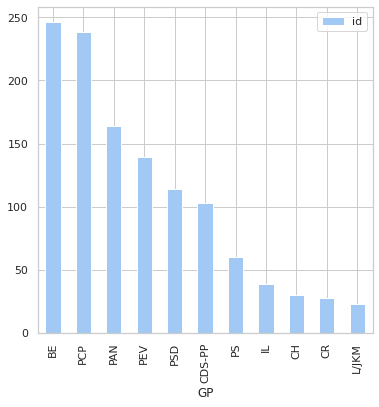

In [10]:
l14af.groupby('GP')[['id']].count().sort_values(by=['id'], axis=0, ascending=False).plot(kind="bar",stacked=True,figsize=(6,6))
plt.show()

```{margin}
Em formato tabular, com os totais.
```

In [11]:
ct = pd.crosstab(l14af.GP, l14af.resultado)
ct["Total"] = ct["Aprovado"] + ct["Rejeitado"]
ct.sort_values(by=['Total'], axis=0, ascending=False)

resultado,Aprovado,Rejeitado,Total
GP,,,
BE,108,138,246
PCP,87,151,238
PAN,68,96,164
PEV,53,86,139
PSD,93,21,114
CDS-PP,54,49,103
PS,59,1,60
IL,11,28,39
CH,1,29,30


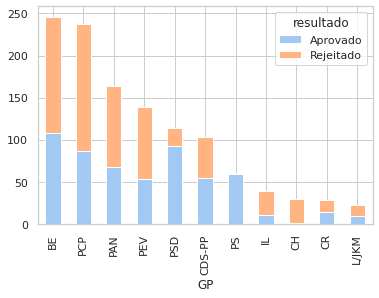

In [12]:
ct.sort_values(by=['Total'], axis=0, ascending=False).drop("Total", axis=1).plot(kind="bar", stacked=True)
plt.show()

Com esta informação, e de forma muito semelhante à utilizada para determinar os apoios às propostas de alteração do Orçamento de Estado, é possível determinar os padrões de votação; o diagrama seguinte mostra a relação entre cada par de partidos: no eixo horizontal quem propõe, e no vertical como votaram:

In [13]:
mycol  = ['GP', 'BE', 'PCP', 'PEV', 'PS', 'L/JKM', 'CR', 'PAN','PSD','IL','CDS-PP', 'CH' ]
df=l14af
submissions_ini = df[mycol]
submissions_ini.head()

,GP,BE,PCP,PEV,PS,L/JKM,CR,PAN,PSD,IL,CDS-PP,CH
99,PSD,A Favor,Contra,Contra,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,Abstenção,Ausência
104,BE,A Favor,A Favor,A Favor,Contra,A Favor,Abstenção,Abstenção,Contra,Contra,Contra,A Favor
105,PCP,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,Contra,Abstenção,Contra,Abstenção
107,CR,A Favor,A Favor,A Favor,Contra,A Favor,A Favor,Abstenção,Contra,Contra,Abstenção,A Favor
109,BE,A Favor,A Favor,A Favor,Contra,A Favor,A Favor,A Favor,Contra,Contra,Contra,Abstenção


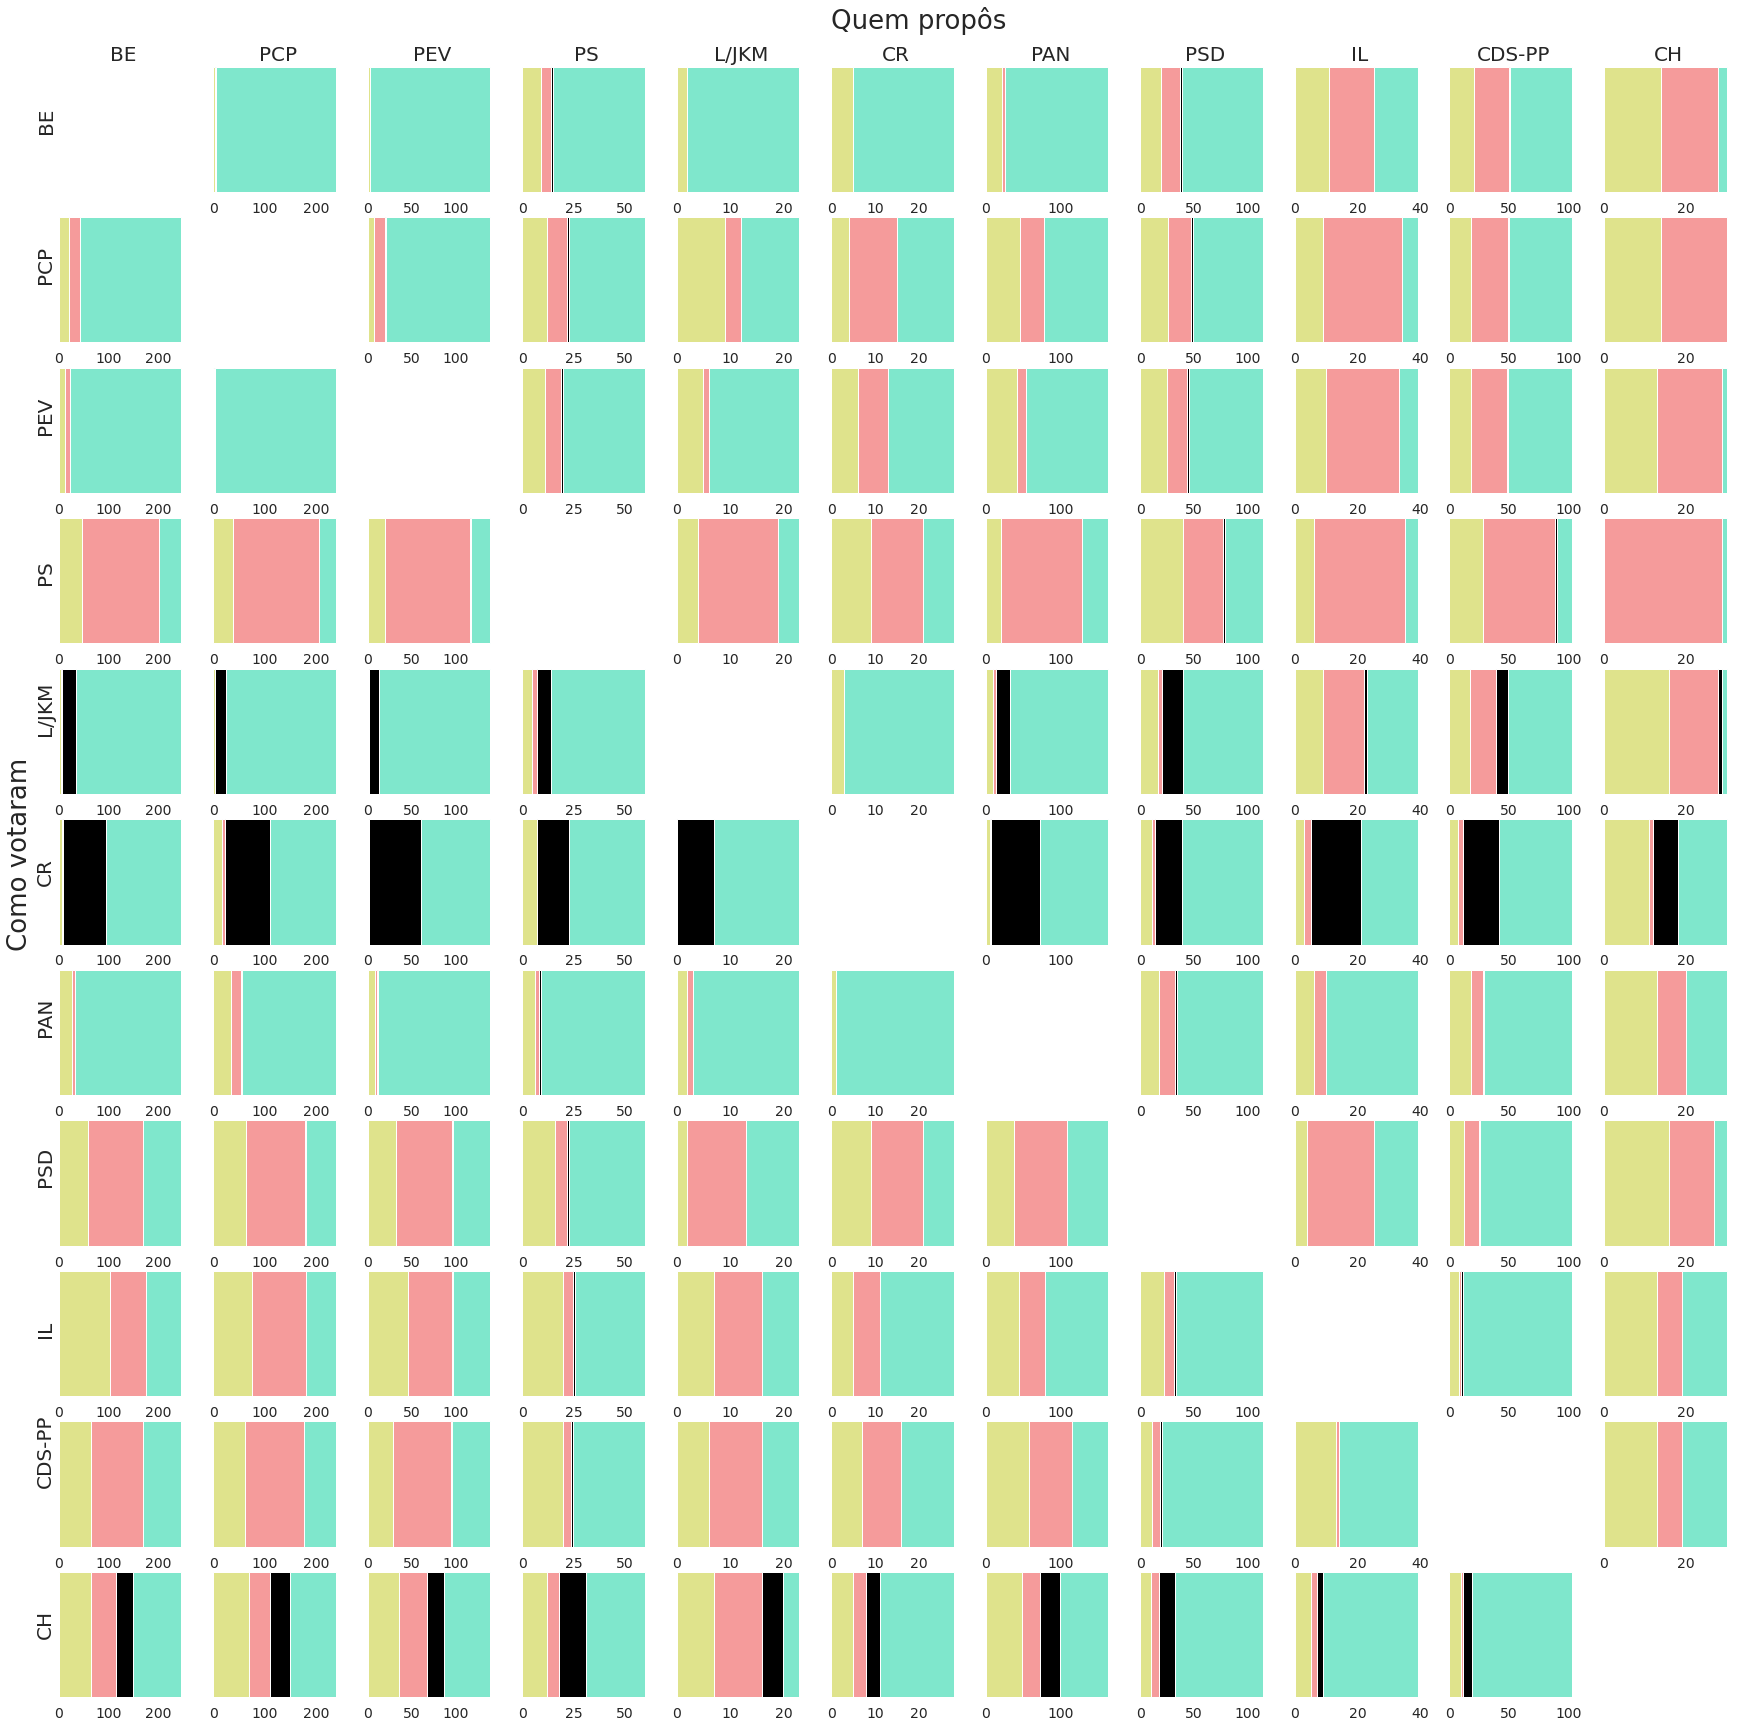

In [14]:
import seaborn as sns
from matplotlib.colors import ListedColormap
#parties   = ['BE', 'PCP', 'PEV', 'PS', 'L', 'PAN','PSD','IL','CDS-PP', 'CH']
#parties   = ['BE', 'PCP','PS', 'PAN','PSD','IL','CDS-PP', 'CH']
parties = ['BE', 'PCP', 'PEV', 'PS', 'L/JKM', 'CR', 'PAN','PSD','IL','CDS-PP', 'CH' ]
gpsubs = submissions_ini

cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#DFE38C","#F59B9B","black","#7FE7CC" ]
cmap = ListedColormap(colors)

spn = 0
fig, axes = plt.subplots(nrows=11, ncols=11, figsize=(30, 30))
axes = axes.ravel()
plt.rcParams.update({'font.size': 22})

for party in parties:
    for p2 in parties:
        sns.set_style("white")
        subp = gpsubs[gpsubs['GP'] == p2][[party]]
        sp = subp.fillna("Ausência").apply(pd.Series.value_counts)
        d = pd.DataFrame(columns=["GP","Abstenção", "Contra", "Ausência","A Favor"]).merge(sp.T, how="right").fillna(0)
        d["GP"] = party
        d = d.set_index("GP")
        d = d[["Abstenção", "Contra", "Ausência","A Favor"]]
        if p2 != party:
            sns.despine(left=True, bottom=True)
            if spn < 11:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap, title=p2,use_index=False,ax=axes[spn], fontsize=12)
                axes[spn].title.set_size(20)
            else:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            axes[spn].get_legend().remove()
            plt.ylim(-4.5, axes[spn].get_yticks()[-1] + 0.5)
            axes[spn].tick_params(labelsize=14)

        else:
            axes[spn].set_xticks([])
            #d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            #axes[spn].get_legend().remove()
            if spn < 11:
                axes[spn].set_title(p2, fontsize=20)
        axes[spn].set_yticks([])
        ## Why? Who knows? Certainly not me. This is likely a side-effect of using a single axis through .ravel
        if spn%11 == 0:
            if spn != 0:
                text = axes[spn].text(-45,0,party,rotation=90, fontsize=20)
            else:
                text = axes[spn].text(-0.17,0.5,party,rotation=90,fontsize=20)
        #print(party, p2)
        #print(d)
        #print("-------------------------_")
        spn += 1

#axes[11].set_axis_off()
text = axes[0].text(6,1.3,"Quem propôs",rotation=0,fontsize=26)
text = axes[0].text(-0.4,-6,"Como votaram",rotation=90,fontsize=26)

#fig.tight_layout()
plt.show()

Uma outra visualização que foca cada gráfico nas propostas de cada partido, e como votaram os restantes_

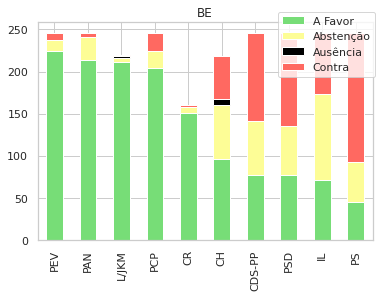

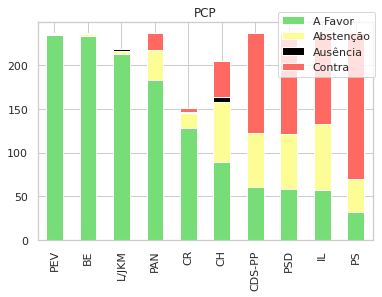

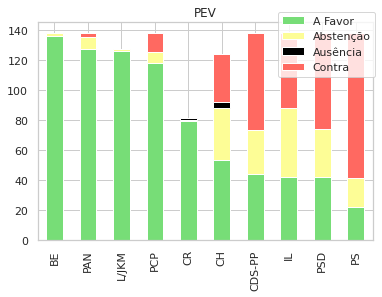

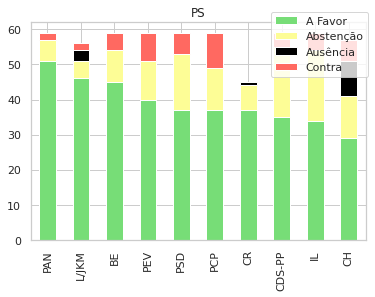

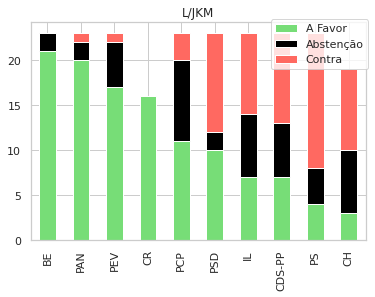

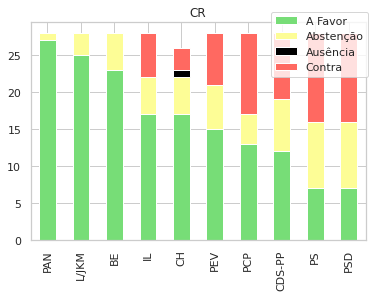

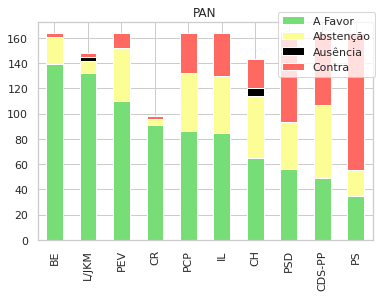

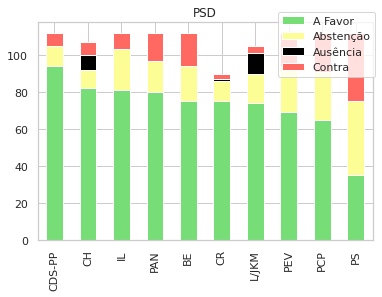

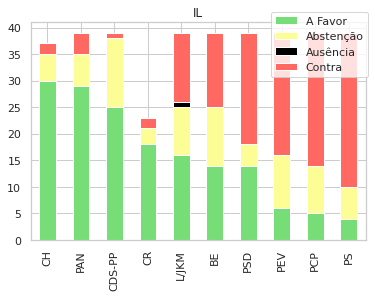

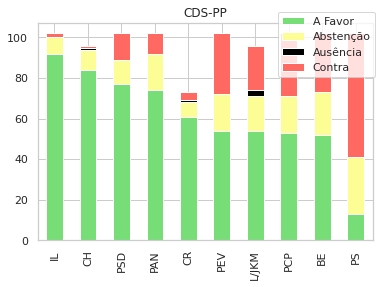

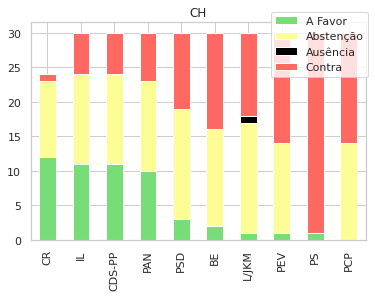

In [15]:
from IPython.display import display
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import cm
parties   = ['BE', 'PCP', 'PEV', 'PS'
             , 'PAN','PSD','IL','CDS-PP', 'CH']
parties = ['BE', 'PCP', 'PEV', 'PS', 'L/JKM', 'CR', 'PAN','PSD','IL','CDS-PP', 'CH' ]

ndf = pd.DataFrame()
#submissions_ini_nu = submissions_ini.loc[submissions_ini['unanime'] != "unanime"]
gpsubs = submissions_ini
cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#77dd77", "#fdfd96",  "black","#ff6961" ]
cmap = ListedColormap(colors)

#spn = 0
#axes = axes.ravel()

for party in parties:
    sns.set_style("whitegrid")
    subp = gpsubs[gpsubs['GP'] == party]
    sp = subp[parties].apply(pd.Series.value_counts).fillna(0).drop([party],axis=1)
    sp = sp.sort_values(by=['A Favor','Abstenção','Contra'], ascending=False, axis=1)
    d = sp.T
    f = plt.figure()
    plt.title(party)
    d.plot(kind='bar', ax=f.gca(), stacked=True, title=party, colormap=cmap,)
    plt.legend(loc='center left',  bbox_to_anchor=(0.7, 0.9),)
    plt.show()
    #print(d)

plt.show()

## Análise

Os dados não divergem do panorama geral obtido por via da análise das votações (sem levar em conta a autoria), ou pelo menos não os contradizem; dada a identificação da autoria uma nova dimensão pode ser 

* BE, PCP, PEV, L/JKM e PAN estão, em ordens diferentes, sempre an metade que mais apoia as propostas de cada um.
* PEV e BE apoiam todas as propostas do PCP, que por sua vez vota maioritariamente a fazer das propostas do BE e PEV mas com algumas abstenções e votos contra (ainda assim, residuais tendo em conta a quantidade de propostas).
* O PCP tem alguns votos contra propostas do PEV, seu parceiro de coligação; olhando para a lista de dados são propostas em torno da caça e tauromaquia.
* As propostas do PS obtêm mais votos favoráveis no PAN e L/JKM, e menos na IL e CH, com os restantes algures no meio.
* Cristina Rodrigues é a maior apoiante do PAN, de onde saiu, e o PS e CDS-PP os que mais vezes votam contra propostas do PAN.
* PSD tem maior suporte à sua direita (CDS-PP, CH, IL), sendo o PS e PCP os que menos votam favoravelmente as suas propostas.
* IL, CH e CDS-PP são os maiores apoiantes mútuos, com a curiosidade de Cristina Rodrigues ser a maior apoiante das propostas do CH (seguida dos restantes).
* O PAN aparece na metade que mais apoia em todo o espectro: é quem mais vota a favor de propostas à esquerda, mas está também no grupo que mais vota a favot de propostas da direita (em particular sendo, a seguir ao CH, quem mais apoia propostas da IL).
* O PCP é o unico partido a não votar favoravelmente nenhuma proposta do CH (embora os votos favoráveis à esquerda sejam residuais nos outros partidos), sendo o PS é o partido que mais vota contra as propostas do mesmo.




In [16]:
lpev = l14af[l14af["GP"] == "PEV"]
with pd.option_context("display.max_colwidth", -1):
    display(lpev[lpev["PCP"] == "Contra"][["iniTitulo"]])


,iniTitulo
521,"Apoio aos trabalhadores da pesca pela suspensão da atividade, devido à COVID-19 através do fundo de compensação salarial dos profissionais da pesca"
710,Define o regime e as condições em que a morte medicamente assistida não é punível
714,"Proíbe a caça à pega-rabuda e exclui esta espécie da Lista de Espécies Cinegéticas e procede à alteração ao Decreto-Lei nº 202/2004, de 18 de agosto"
716,"Proíbe a caça ao gaio, exclui esta espécie da Lista de Espécies Cinegéticas e procede à alteração ao Decreto-Lei nº 202/2004, de 18 de agosto"
718,"Proíbe a caça à gralha-preta, exclui esta espécie da Lista de Espécies Cinegéticas e procede à alteração ao Decreto-Lei nº 202/2004, de 18 de agosto"
720,"Proíbe a caça ao melro, exclui esta espécie da Lista de Espécies Cinegéticas e procede à alteração ao Decreto-Lei nº 202/2004, de 18 de agosto"
722,"Proíbe a caça ao saca-rabos, exclui esta espécie da Lista de Espécies Cinegéticas e procede à alteração ao Decreto-Lei nº 202/2004, de 18 de agosto"
724,"Proíbe a caça à raposa, exclui esta espécie da Lista de Espécies Cinegéticas e procede à alteração ao Decreto-Lei nº 202/2004, de 18 de agosto"
920,Impede o financiamento público aos espetáculos tauromáquicos
2440,Instrumentos de gestão do arvoredo em meio urbano
